In [1]:
import pandas as pd
import torch

from models.lstm import (create_model, create_sequences, evaluate_model,
                         train_model)
from utils.plotting import plot_train_val, plot_train_val_losses, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              interpolate_missing_hours, split_train_val)

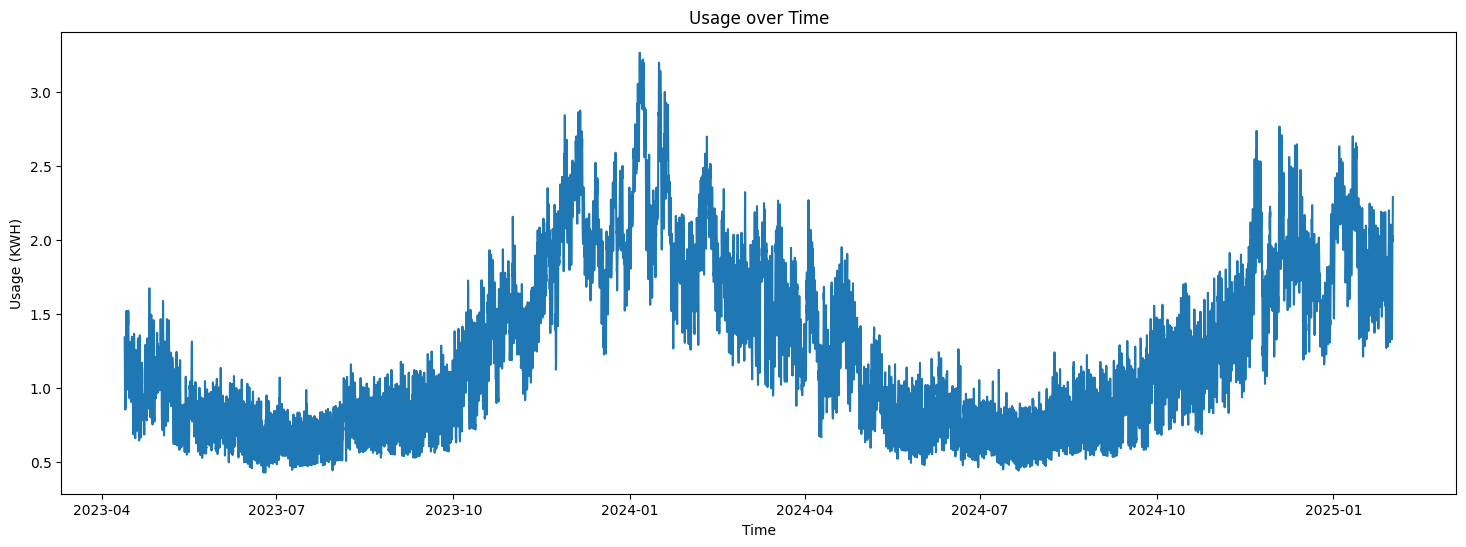

In [2]:
df_raw = pd.read_csv('data/cons_se3_mean.csv')
df = interpolate_missing_hours(df_raw)
df = add_time_based_features(df)

spot_price_path = 'data/spotprices.csv'
se_area = 'SE3'
df = add_spotprice(df, spot_price_path, se_area)

plot_usage(df)

In [3]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,USAGE_KWH,SPOTPRICE_SEK_BY_KWH
0,2023-04-13 00:00:00+00:00,4,13,3,0,1.341355,0.01136
1,2023-04-13 01:00:00+00:00,4,13,3,1,1.284330,0.01009
2,2023-04-13 02:00:00+00:00,4,13,3,2,1.131421,0.01122
3,2023-04-13 03:00:00+00:00,4,13,3,3,1.021122,0.05652
4,2023-04-13 04:00:00+00:00,4,13,3,4,0.988575,0.35948
...,...,...,...,...,...,...,...
15835,2025-01-31 19:00:00+00:00,1,31,4,19,2.022736,1.43054
15836,2025-01-31 20:00:00+00:00,1,31,4,20,1.988702,0.88248
15837,2025-01-31 21:00:00+00:00,1,31,4,21,2.076348,0.86239
15838,2025-01-31 22:00:00+00:00,1,31,4,22,2.256457,0.51394


In [4]:
# NOTE: Variables for Sequence generation, splitting, and scaling

sequence_length = 24
window = 24

train_split = 0.9
scaler_type = 'minmax'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X, y = create_sequences(df, sequence_length, window)


X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, train_split, scaler_type, device)

Using device: cpu
Applying minmax scaling.
X_train shape: torch.Size([14212, 24, 5])
y_train shape: torch.Size([14212, 1])
X_val shape: torch.Size([1580, 24, 5])
y_val shape: torch.Size([1580, 1])


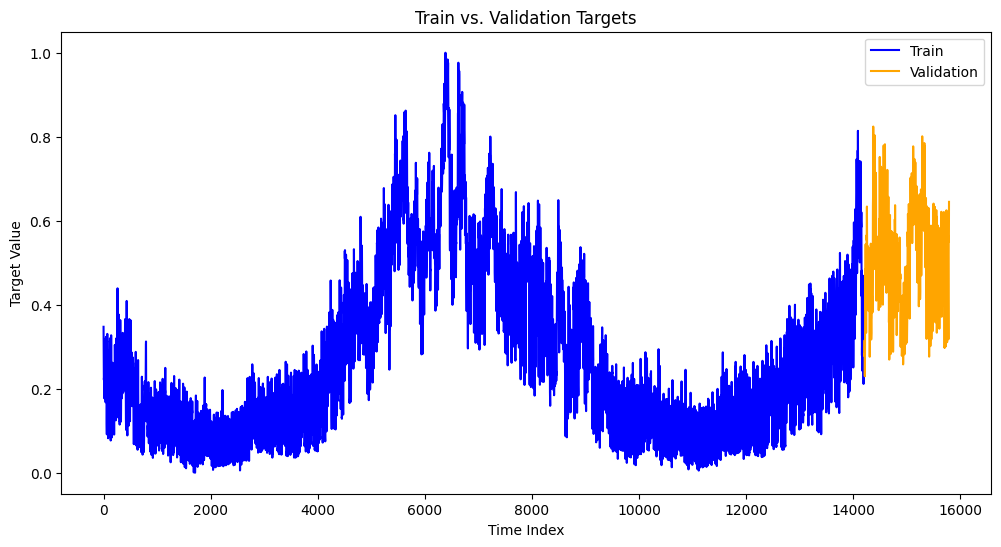

In [5]:
plot_train_val(y_train, y_val)

In [6]:
# NOTE: Model variables

input_dim = X_train.shape[2]
hidden_dim = 50
num_layers = 2
output_dim = 1

model = create_model(input_dim, hidden_dim, num_layers, output_dim, device)

model

LSTMModel(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [7]:
# NOTE: Training variables

num_epochs=100
initial_lr=0.01
gamma=0.9
noise_std=0.05

train_losses, val_losses, model = train_model(
        model, X_train, y_train, X_val, y_val,
        num_epochs, initial_lr, gamma, noise_std
    )

Applying Adaptive LR Scheduler: Step Size = 20 epochs, Decay Factor = 0.9
Applying gaussian noise: std = 0.05
Epoch 1/100, Train Loss: 0.0743, Val Loss: 0.0482
Epoch 2/100, Train Loss: 0.0392, Val Loss: 0.0447
Epoch 3/100, Train Loss: 0.0381, Val Loss: 0.0736
Epoch 4/100, Train Loss: 0.0353, Val Loss: 0.0802
Epoch 5/100, Train Loss: 0.0350, Val Loss: 0.0598
Epoch 6/100, Train Loss: 0.0308, Val Loss: 0.0306
Epoch 7/100, Train Loss: 0.0287, Val Loss: 0.0219
Epoch 8/100, Train Loss: 0.0236, Val Loss: 0.0320
Epoch 9/100, Train Loss: 0.0156, Val Loss: 0.0169
Epoch 10/100, Train Loss: 0.0081, Val Loss: 0.1475
Epoch 11/100, Train Loss: 0.0479, Val Loss: 0.0820
Epoch 12/100, Train Loss: 0.0426, Val Loss: 0.1013
Epoch 13/100, Train Loss: 0.0427, Val Loss: 0.0820
Epoch 14/100, Train Loss: 0.0309, Val Loss: 0.0607
Epoch 15/100, Train Loss: 0.0237, Val Loss: 0.0430
Epoch 16/100, Train Loss: 0.0214, Val Loss: 0.0299
Epoch 17/100, Train Loss: 0.0228, Val Loss: 0.0219
Epoch 18/100, Train Loss: 0.0260

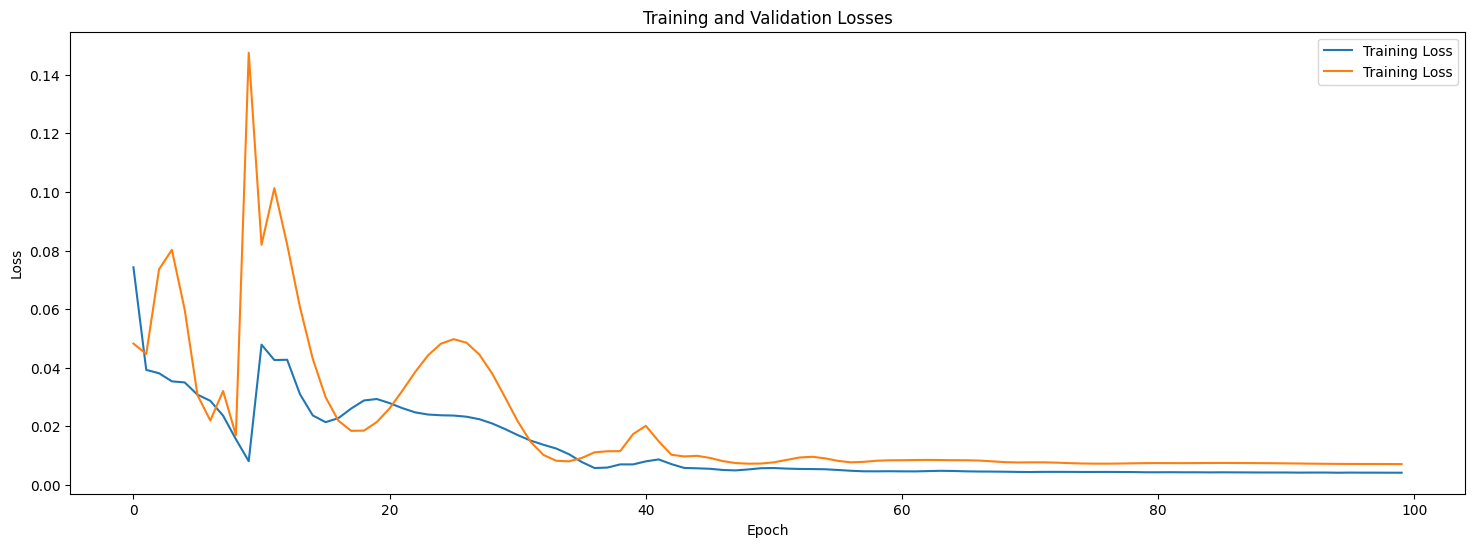

In [8]:
plot_train_val_losses(train_losses, val_losses)

MAE: 0.1891
MAPE: 10.46%
RMSE: 0.2385
kWh actual: 2919.4140625, kWh pred: 2892.105712890625, diff (%): 0.9354051351547241


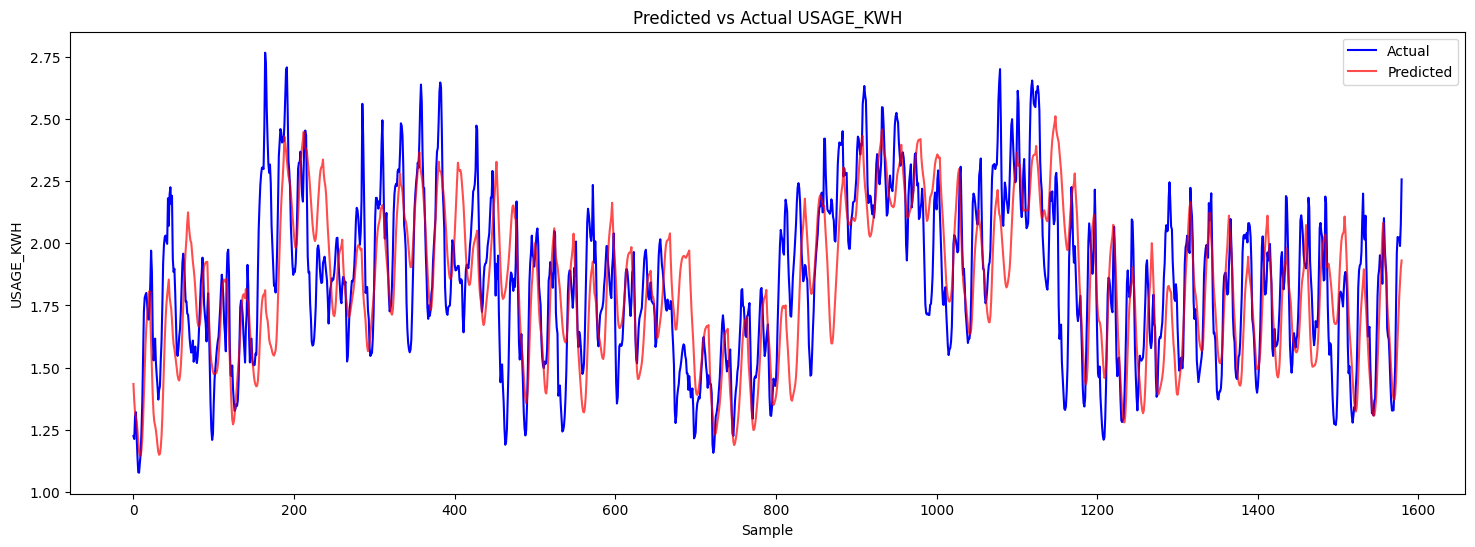

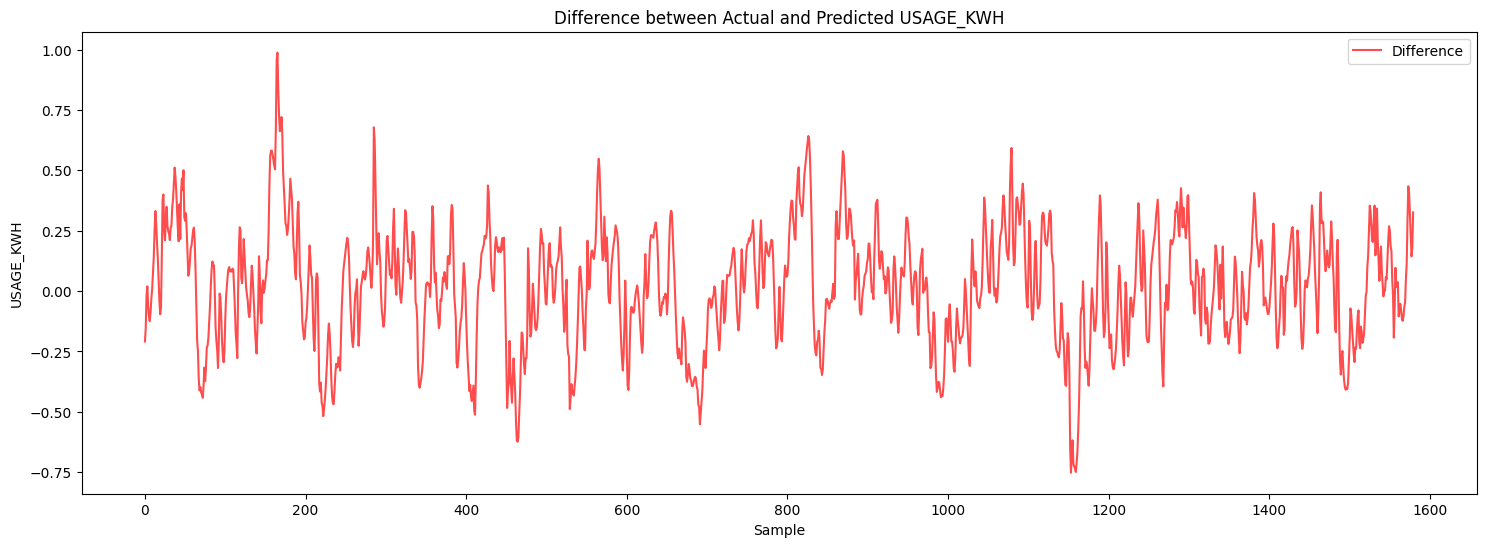

In [10]:
_ = evaluate_model(model, X_val, y_val, scaler_y)